In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

### 1. Implement a simulation of the k-armed bandits environment, with a variable value of $k$ (should be configurable) and random $p_i$ probabilities to obtain a reward of $0$ or $1$ from pulling each machine. The probabilities should be different each time you instance the environment.

### 2. Build an algorithm that implements one of the exploration strategies and run it for a specified amount of time on $k=10$ armed bandits. Gather the obtained rewards and use them to train a supervised model that estimates the value of pulling each of the $k$ machines.

In [3]:
class Arm:
    def __init__(self,prob):
        """
        prob: probability of getting 1
        """
        self.prob = prob
        self.pulled_total = 0
        self.reward_total=0
        self.mean = 0
        
    def pull(self):
        reward = 1 if np.random.rand() <= self.prob else 0
        
        self.pulled_total += 1
        self.reward_total += reward
        self.mean = (self.reward_total * 1.0) / self.pulled_total
        
        return reward
    
    def reset(self):
        self.pulled_total = 0
        self.reward_total=0
        self.mean = 0
        
class GreedyStrategy:
    def __init__(self, prob):
        """
        prob: probability of exploration
        """
        self.prob = prob
        
    def run(self, arms):
        prob = random.random()
        
        if prob > self.prob:
            q_val=[a.mean for a in arms]
            max_policies = np.argwhere(q_val == np.amax(q_val))
            
            return max_policies[np.random.randint(0,len(max_policies))][0]  
        else:
            return random.randint(0,len(arms)-1)
            
        
class MultiArmedBandit:
    def __init__(self,k):
        self.arms = [Arm(np.random.uniform(0,1)) for i in range(k)]
        
    def reset_arms(self):
        for arm in self.arms:
            arm.reset()
        
    def run(self, iteration_count, strategy):
        rewards = np.empty(iteration_count)         
        
        for i in range(iteration_count):
            arm = strategy.run(self.arms)
            
            reward = self.arms[arm].pull()
            rewards[i] = reward

        return rewards

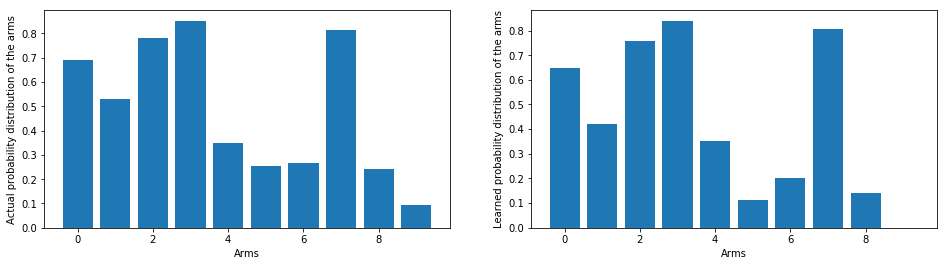

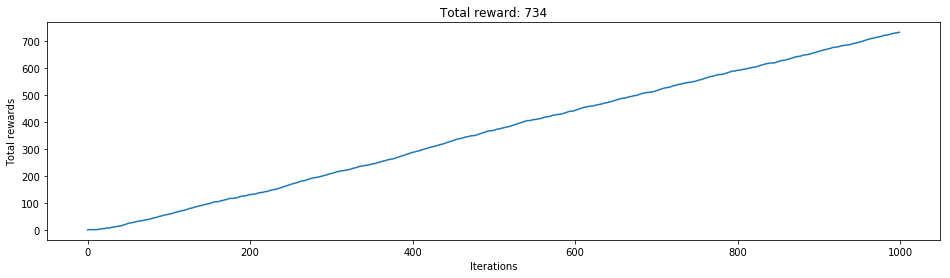

In [4]:
def plot_learned_model(bandit, rewards):
    plt.figure(figsize=(16,4))
    
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(10), [a.prob for a in bandit.arms])
    plt.xlabel('Arms')
    plt.ylabel('Actual probability distribution of the arms')
    
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), [a.mean for a in bandit.arms])
    plt.xlabel('Arms')
    plt.ylabel('Learned probability distribution of the arms')
    
    plt.show()
    
    plt.figure(figsize=(16,4))
    
    title = 'Total reward: {}'.format(int(np.sum(rewards)))
    plt.subplot(1, 1, 1)
    plt.plot(np.cumsum(rewards))
    plt.xlabel('Iterations')
    plt.ylabel('Total rewards')
    plt.title(title)
    
    plt.show()

iteration_count = 1000
bandit = MultiArmedBandit(10)
strategy = GreedyStrategy(0.2)

rewards = bandit.run(iteration_count, strategy)

plot_learned_model(bandit, rewards)

### 3. Using the learned model, estimate a policy for the environment and execute it on the same environment (with the same probabilities). Report the obtained results.

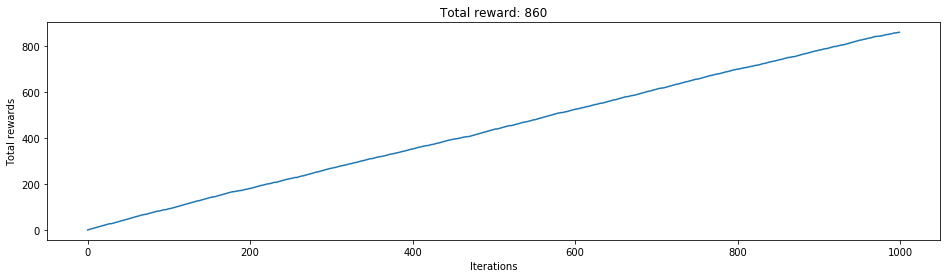

In [5]:
def use_learned_model(bandit):
    learned_policy = np.argmax([a.prob for a in bandit.arms])
    
    rewards = np.empty(iteration_count)
    for i in range(iteration_count):
        arm = bandit.arms[learned_policy]
        reward = 1 if np.random.rand() <= arm.prob else 0
        rewards[i] = reward
    
    title = 'Total reward: {}'.format(int(np.sum(rewards)))
    
    plt.figure(figsize=(16,4))
    plt.subplot(1, 1, 1)
    plt.plot(np.cumsum(rewards))
    plt.xlabel('Iterations')
    plt.ylabel('Total rewards')
    plt.title(title)
    
    plt.show()
    
use_learned_model(bandit)

### 4. Repeat parts 2 and 3, but now automate it with code and vary k from 10 to 1000 in steps of 10/50 as appropriate (depending on computation availability), and report the if increasing the value of k makes the problem "harder", using several metrics like the normalized reward (total reward / k) or the number of times the algorithm fails to converge and produces bad results, or if the algorithm learns sub-optimal policies. For statistical stability, you might repeat each instance of using a value of k multiple times, with different probabilities in each run.

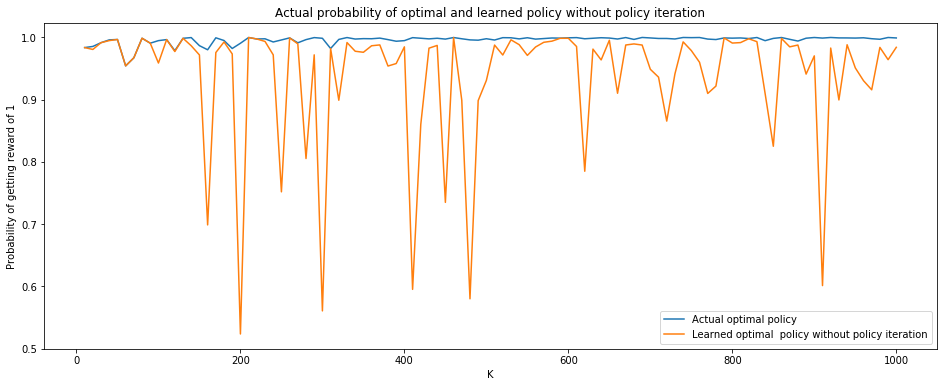

In [34]:
k_values=np.arange(10,1001,10)

best_prob = np.empty(len(k_values))
learned_prob = np.empty(len(k_values))

index = 0
for i, k in enumerate(k_values):
    bandit = MultiArmedBandit(k)
    strategy = GreedyStrategy(0.2)

    bandit.run(iteration_count, strategy)
    
    best_policy = np.argmax([a.prob for a in bandit.arms])
    learned_policy = np.argmax([a.mean for a in bandit.arms])
    
    best_prob[i] = bandit.arms[best_policy].prob
    learned_prob[i] = bandit.arms[learned_policy].prob
    
plt.figure(figsize=(16,6))

plt.plot(k_values, best_prob)
plt.plot(k_values, learned_prob)

plt.legend(['Actual optimal policy',
            'Learned optimal  policy without policy iteration'])
plt.xlabel('K')
plt.ylabel('Probability of getting reward of 1')
plt.title('Actual probability of optimal and learned policy without policy iteration')
plt.show()

The plot shows actual probability of optimal and learned policy without policy iteration. From the plot we can see that the model learns sub obtimal policies in case of increased k values.

#### 5. Repeat part 4 but now interleave policy learning for a certain number of iterations, and then exploiting that policy during exploration in order to improve the model (like Q-Learning does). Does this actually improve the model, or it leads to premature convergence to a sub-optimal policy? Compare your results with the ones obtained in part 4.

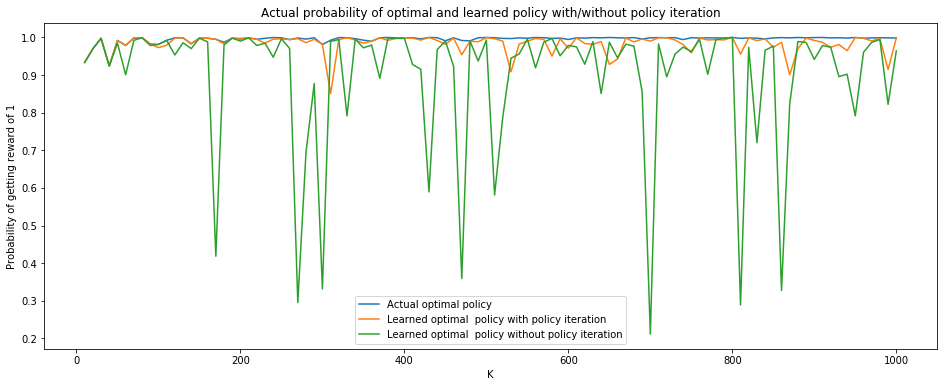

In [33]:
k_values=np.arange(10,1001,10)

best_prob = np.empty(len(k_values))
learned_prob = np.empty(len(k_values))
learned_prob_improved = np.empty(len(k_values))

index = 0
for i, k in enumerate(k_values):
    bandit = MultiArmedBandit(k)
    strategy = GreedyStrategy(0.2)
    
    bandit.run(iteration_count, strategy)
    
    best_policy = np.argmax([a.prob for a in bandit.arms])
    learned_policy = np.argmax([a.mean for a in bandit.arms])
    
    best_prob[i] = bandit.arms[best_policy].prob
    learned_prob[i] = bandit.arms[learned_policy].prob
    
    learned_policy_count = 0
    last_policy = -1
    while(True):
        bandit.reset_arms()
        bandit.run(iteration_count, strategy)
        
        learned_policy = np.argmax([a.mean for a in bandit.arms])
    
        if(last_policy == learned_policy):
            learned_policy_count +=1
        else:
            last_policy = learned_policy
            
        if (learned_policy_count == 2):
            learned_prob_improved[i] = bandit.arms[learned_policy].prob
            
            break
    
plt.figure(figsize=(16,6))

plt.plot(k_values, best_prob)
plt.plot(k_values, learned_prob_improved)
plt.plot(k_values, learned_prob)

plt.legend(['Actual optimal policy', 'Learned optimal  policy with policy iteration',
            'Learned optimal  policy without policy iteration'])
plt.xlabel('K')
plt.ylabel('Probability of getting reward of 1')
plt.title('Actual probability of optimal and learned policy with/without policy iteration')
plt.show()

The plot shows actual probability of optimal and learned policy with/without policy iteration. From the plot, we can see that policy iteration gives policy value closer to the actual one even in case of higher $k$ value.

#### 6. Comment on the failure cases and sub-optimal policies that you have observed during your experimentations.


We get more sub optimal policy in case of higher $k$ values. However, higher number of iterations (we used 1000) in case of high $k$ values finds more optimal result in both the cases of with and without policy iteration.